In [90]:
import imgtda

import numpy as np
import pandas as pd
from scipy import misc
from matplotlib import pyplot as plt
from skimage import morphology as morph
from scipy import stats
from skimage import measure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

## Set Up Project

In [3]:
myproject = imgtda.Project

myproject['directory'] = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast'
myproject['bmp_format'] = 'g21flow/bmps/%06d.bmp'
myproject['pd_sub_format'] = 'g21flow/pd_sub/%06d.csv'
myproject['pd_sup_format'] = 'g21flow/pd_sup/%06d.csv'
myproject['additional_data'] = {'lyap_format':'g21per/bmps_abs_val/%05d.bmp',
                                'delta':40}


## Utility Functions

In [4]:
def load_image_data(project, idx):
    
    im = imgtda.image.load_image_from_file(project['directory'] + "/" + (project['bmp_format'] % idx))
    im.load_sublevel_pd(project['directory'] + "/" + (project['pd_sub_format'] % idx))
    im.load_superlevel_pd(project['directory'] + "/" + (project['pd_sup_format'] % idx))
    
    return im

def load_lyap_data(project, idx):
    
    lyap = misc.imread(project['directory'] + "/" + (project['additional_data']['lyap_format'] % idx))
    
    return lyap

def cropping_region():
    # Plot the results
    # Crop the temperature field to a circle first.
    c = np.zeros((421,421))
    centerx = 210
    centery = 210
    radius=200
    for i in range(c.shape[0]):
        for j in range(c.shape[1]):
            if ((i-centerx)**2 + (j-centery)**2 < radius**2):
                c[i,j] = 1
    c = c.astype(np.int)

    return c

## The Code

In [5]:
def get_image_defects(idx, sigma, radius):

    im = load_image_data(myproject, idx)
    im.generate_orientation_field(sigma,1)
    im.get_persistent_h1_generators(myproject['additional_data']['delta'])

    return im

def get_image_saddle_points(im, lowercutoff, uppercutoff, delta):
    
    # Generate persistent homology defect matrix
    ph_lower_saddles = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==0) & ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & (im.persistence_diagrams['sub']['death']>=lowercutoff) & (im.persistence_diagrams['sub']['death']<=127)][['d_x','d_y']]
    ph_lower_saddles.columns = ['col', 'row']
    ph_tmp = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==1) & ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & (im.persistence_diagrams['sub']['birth']>=lowercutoff) & (im.persistence_diagrams['sub']['birth']<=127)][['b_x','b_y']]
    ph_tmp.columns = ['col', 'row']
    ph_lower_saddles = pd.concat([ph_lower_saddles, ph_tmp])

    ph_upper_saddles = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==0) & ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & (im.persistence_diagrams['sup']['death']>=127) & (im.persistence_diagrams['sup']['death']<=uppercutoff)][['d_x','d_y']]
    ph_upper_saddles.columns = ['col', 'row']
    ph_tmp = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==1) & ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & (im.persistence_diagrams['sup']['birth']>=127) & (im.persistence_diagrams['sup']['birth']<=uppercutoff)][['b_x','b_y']]
    ph_tmp.columns = ['col', 'row']
    ph_upper_saddles = pd.concat([ph_upper_saddles, ph_tmp])
    
    saddle_points = pd.concat([ph_lower_saddles, ph_upper_saddles])
    
    saddle_matrix = np.zeros(im.bmp.shape)
    saddle_matrix[saddle_points['row'], saddle_points['col']] = 1
    
    return saddle_matrix


## Process Images

In [6]:
from pprint import pprint as pp

sigma = 3
radius = 15
lowercutoff = 45
uppercutoff = 200
delta_saddle = 10

lyap_cutoffs = [0.2, 0.5, 0.8]

process_range = range(100, 3500)

lyap_stats = {}

for idx in process_range:
    
    if idx % 50 == 0:
        print idx
    
    lyap_stats[idx] = {}
    
    c = cropping_region()
    total_area = float(np.sum(c))
    
    im = get_image_defects(idx, sigma, radius)
    im.saddle_points = get_image_saddle_points(im, lowercutoff, uppercutoff, delta_saddle)
    im.saddle_points = np.multiply(im.saddle_points, c)
    im.persistence_h1_gens = np.multiply(im.persistence_h1_gens, c)
    
    topological_defects_dilated = morph.binary_dilation(im.orientation_fields[sigma].topological_defects, morph.disk(radius))
    saddle_points_dilated = morph.binary_dilation(im.saddle_points, morph.disk(radius))
    persistence_h1_gens_dilated = morph.binary_dilation(im.persistence_h1_gens, morph.disk(radius))
    all_ph_dilated = ((saddle_points_dilated+persistence_h1_gens_dilated)>0).astype(np.int)

    lyap = load_lyap_data(myproject, idx)
    lyap = lyap.astype(np.int)/255.
    lyap = np.multiply(lyap, c)
    
    
    for cutoff in lyap_cutoffs:
        lyap_thresholded = (lyap >= cutoff).astype(np.int)
        lyap_thresholded_area = float(np.sum(lyap_thresholded))
    
        # Compute percentages inside of cropped region
        if lyap_thresholded_area > 0:
            lyap_stats[idx][cutoff] = {
                # w/in radius of topological defect
                'topological': np.sum(np.multiply(lyap_thresholded, topological_defects_dilated))/lyap_thresholded_area, 
                # w/in radius of persistent homology defect
                'saddle': np.sum(np.multiply(lyap_thresholded, saddle_points_dilated))/lyap_thresholded_area,
                # w/in radius of persistent homology H1 defect
                'h1_gen': np.sum(np.multiply(lyap_thresholded, persistence_h1_gens_dilated))/lyap_thresholded_area,
                # w/in radius of either saddle or H1 ph defect
                'all_ph_gens': np.sum(np.multiply(lyap_thresholded, all_ph_dilated))/lyap_thresholded_area
            }
        else:
            lyap_stats[idx][cutoff] = {
                # w/in radius of topological defect
                'topological': 0., 
                # w/in radius of persistent homology defect
                'saddle': 0.,
                # w/in radius of persistent homology H1 defect
                'h1_gen': 0.,
                # w/in radius of either saddle or H1 ph defect
                'all_ph_gens': 0.
            }



100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450


/Users/birdbrain/anaconda/lib/python2.7/site-packages/imgtda/core/image.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  persistence_h1_gens[h1gens['row'], h1gens['col']] = 1


In [7]:
# Generate plots of time series of percentages

lyap_stats_matrix = np.zeros((len(process_range), len(lyap_cutoffs), 4))

for i in range(len(process_range)):
    for j in range(len(lyap_cutoffs)):
        lyap_stats_matrix[i, j, 0] = lyap_stats[process_range[i]][lyap_cutoffs[j]]['topological']
        lyap_stats_matrix[i, j, 1] = lyap_stats[process_range[i]][lyap_cutoffs[j]]['saddle']
        lyap_stats_matrix[i, j, 2] = lyap_stats[process_range[i]][lyap_cutoffs[j]]['h1_gen']
        lyap_stats_matrix[i, j, 3] = lyap_stats[process_range[i]][lyap_cutoffs[j]]['all_ph_gens']
        

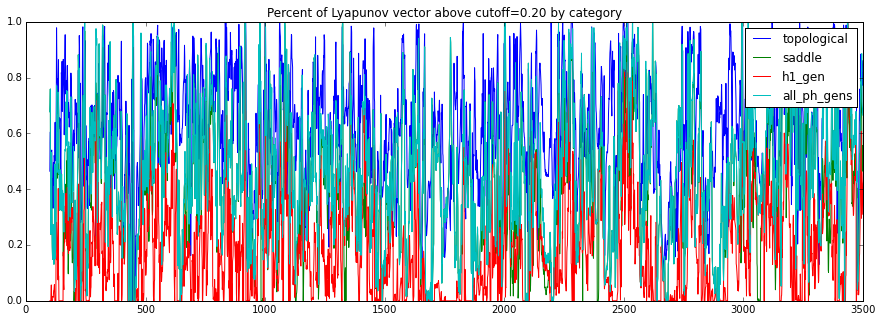

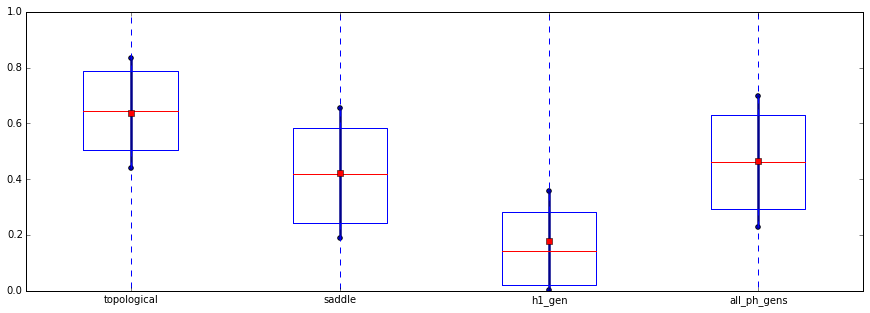

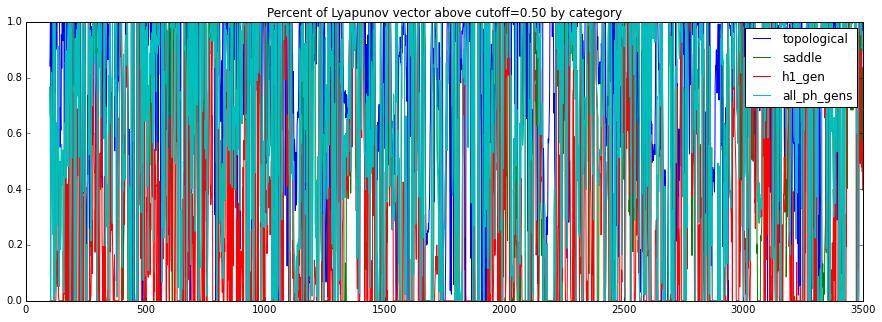

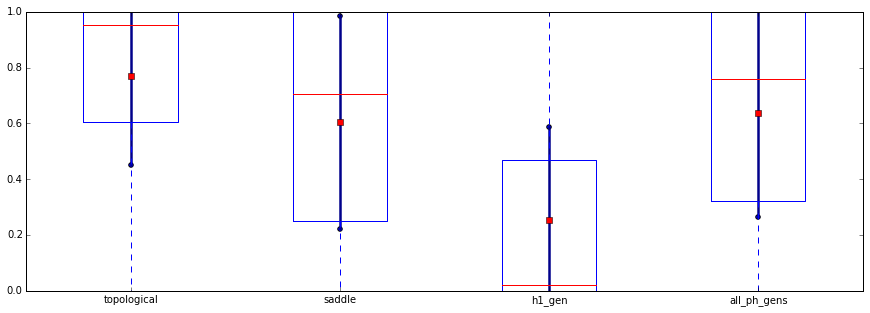

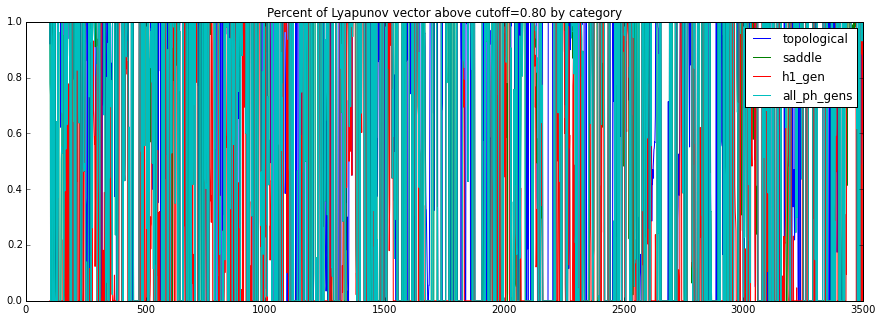

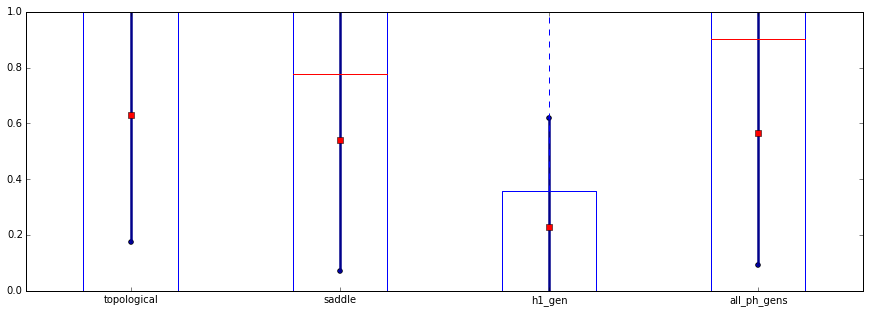

In [13]:

plt.rcParams['figure.figsize'] = (15.0, 5.0);

labels = ['topological', 'saddle', 'h1_gen', 'all_ph_gens']

for j in range(len(lyap_cutoffs)):

    for i in range(len(labels)):
        plt.plot(process_range, lyap_stats_matrix[:,j,i], label=labels[i])
    plt.legend()
    plt.title('Percent of Lyapunov vector above cutoff=%0.2f by category' % lyap_cutoffs[j])
    plt.show()
    
    
    means = np.asarray([np.mean(lyap_stats_matrix[:, j, i]) for i in range(len(labels))])
    coeff_var = np.asarray([np.std(lyap_stats_matrix[:, j, i]) for i in range(len(labels))])
    lower_estimate = means - coeff_var
    upper_estimate = means + coeff_var

    for i in range(len(labels)):
        plt.plot([i+1,i+1], [lower_estimate[i], upper_estimate[i]], linewidth=2.5, color='darkblue')
    plt.scatter(range(1,len(labels)+1), lower_estimate)
    plt.scatter(range(1,len(labels)+1), upper_estimate)
    
    plt.boxplot(lyap_stats_matrix[:,j,:], labels=labels, showfliers=False, showmeans=True, whis=1000)
    plt.ylim([0,1])
    plt.show()

## View a single image

In [112]:
def plot_single_image_lyap(idx, sigma, radius, cutoff):

    c = cropping_region()
    total_area = float(np.sum(c))

    im = get_image_defects(idx, sigma, radius)
    im.orientation_fields[sigma].topological_defects = np.multiply(im.orientation_fields[sigma].topological_defects, c)
    im.saddle_points = get_image_saddle_points(im, lowercutoff, uppercutoff, delta_saddle)
    im.saddle_points = np.multiply(im.saddle_points, c)
    im.persistence_h1_gens = np.multiply(im.persistence_h1_gens, c)
    im.bmp = np.multiply(im.bmp, c)

    topological_defects_dilated = morph.binary_dilation(im.orientation_fields[sigma].topological_defects, morph.disk(radius))
    saddle_points_dilated = morph.binary_dilation(im.saddle_points, morph.disk(radius))
    persistence_h1_gens_dilated = morph.binary_dilation(im.persistence_h1_gens, morph.disk(radius))
    all_ph_dilated = ((saddle_points_dilated+persistence_h1_gens_dilated)>0).astype(np.int)

    lyap = load_lyap_data(myproject, idx)
    lyap = lyap.astype(np.int)/255.
    lyap = np.multiply(lyap, c)


    # Find contours at median temperature value
    contours = measure.find_contours(im.bmp, 127.)

    # Display the image and plot all contours found
    plt.rcParams['figure.figsize'] = (12.0, 12.0);
    plt.figure()
    ax = plt.gca()
    plt.gca().set_axis_off()


    # plot_lyap = plt.imshow(lyap, interpolation='nearest', cmap=plt.cm.gray)

    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # plt.colorbar(plot_lyap, cax=cax)

    # plt.set_cmap('jet')


    lyap_thresholded = np.ma.masked_where(lyap >= cutoff, np.zeros(im.bmp.shape))

    colors_red = [(1, 1, 1), (1, 1, 0)] 
    cmap_name = 'w2r'
    cmap_red = LinearSegmentedColormap.from_list(
            cmap_name, colors_red, N=2)

    colors_blue = [(1, 1, 1), (0, 1, 1)] 
    cmap_name = 'w2b'
    cmap_blue = LinearSegmentedColormap.from_list(
            cmap_name, colors_blue, N=2)


    td_layer = plt.imshow(topological_defects_dilated, cmap=cmap_blue, interpolation='nearest')
    ph_layer = plt.imshow(all_ph_dilated,alpha=.5, cmap=cmap_red, interpolation='nearest')
    lyap_layer = plt.imshow(lyap_thresholded,alpha=.5, cmap='gray', interpolation='nearest')

    for n, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='black')
        ax.set_xlim([0,im.bmp.shape[0]])
        ax.set_ylim([im.bmp.shape[0], 0])

    plt.show()

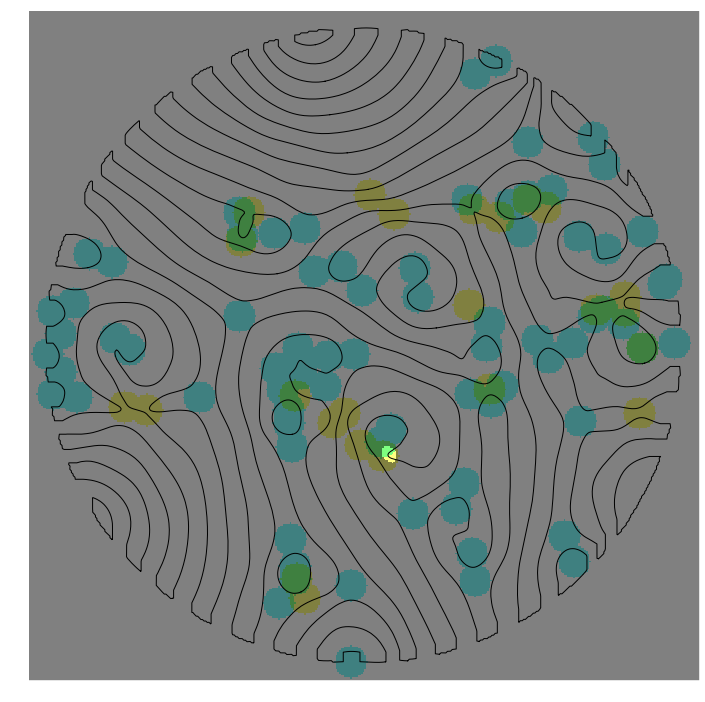

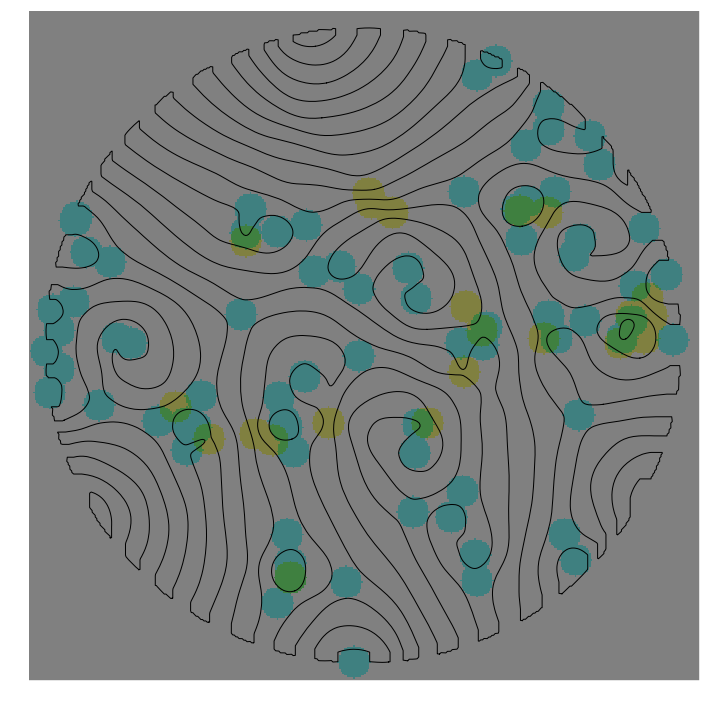

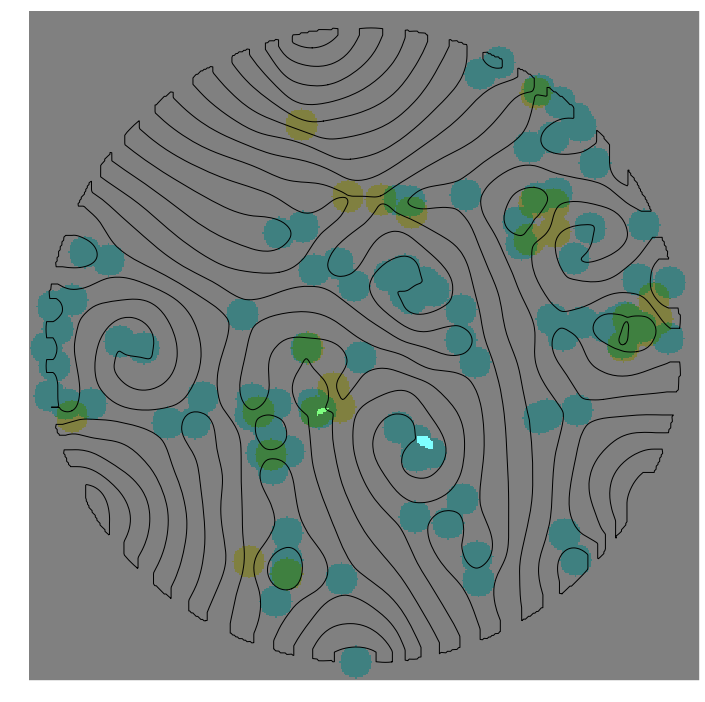

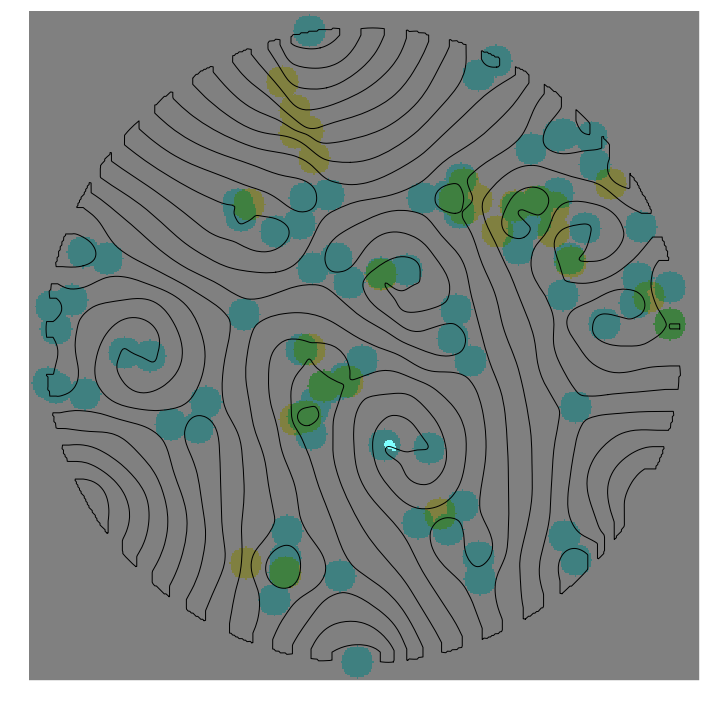

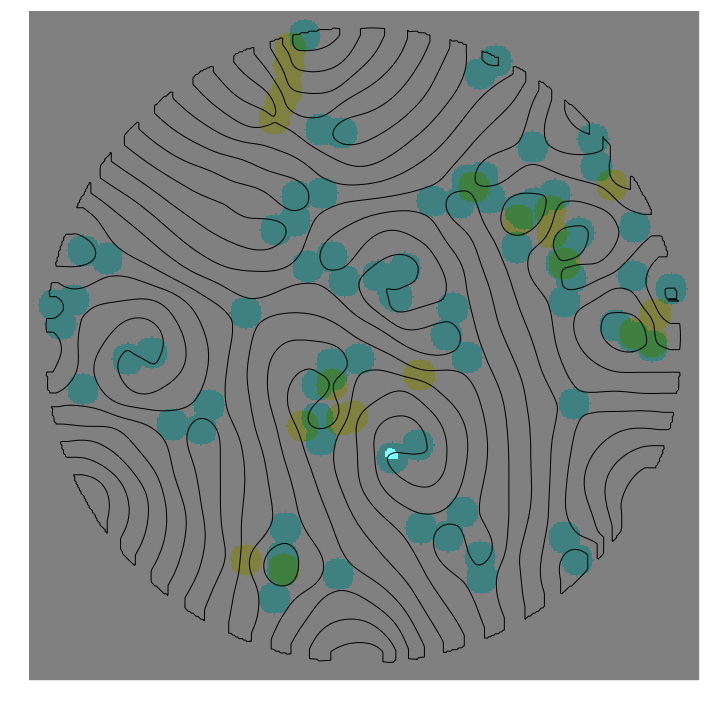

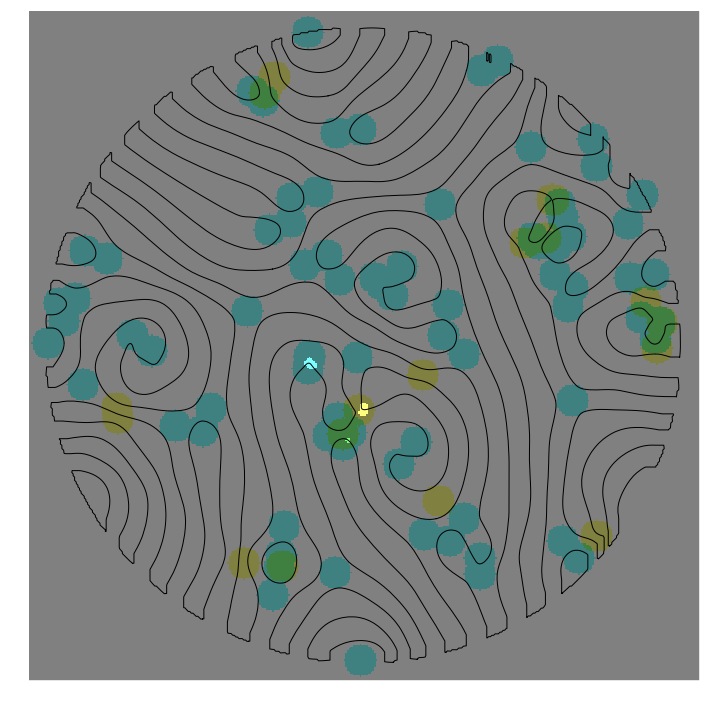

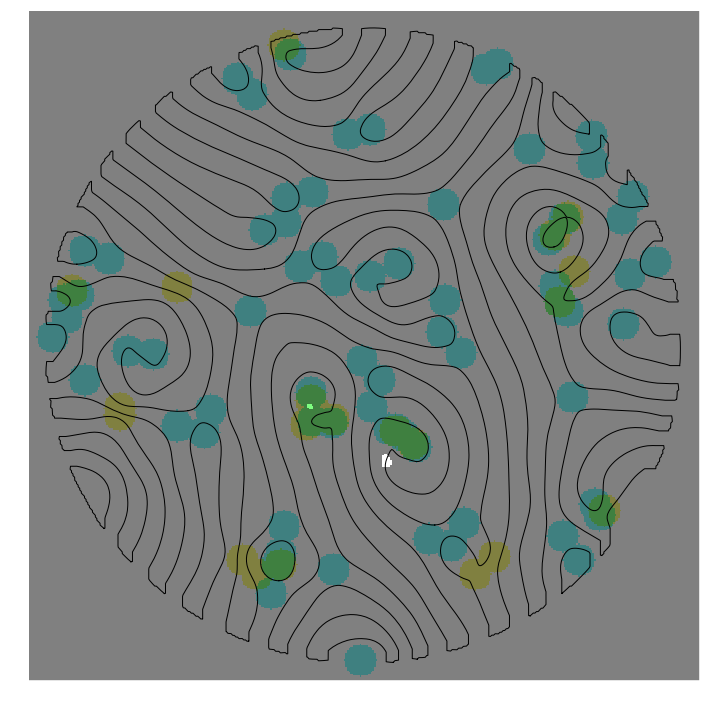

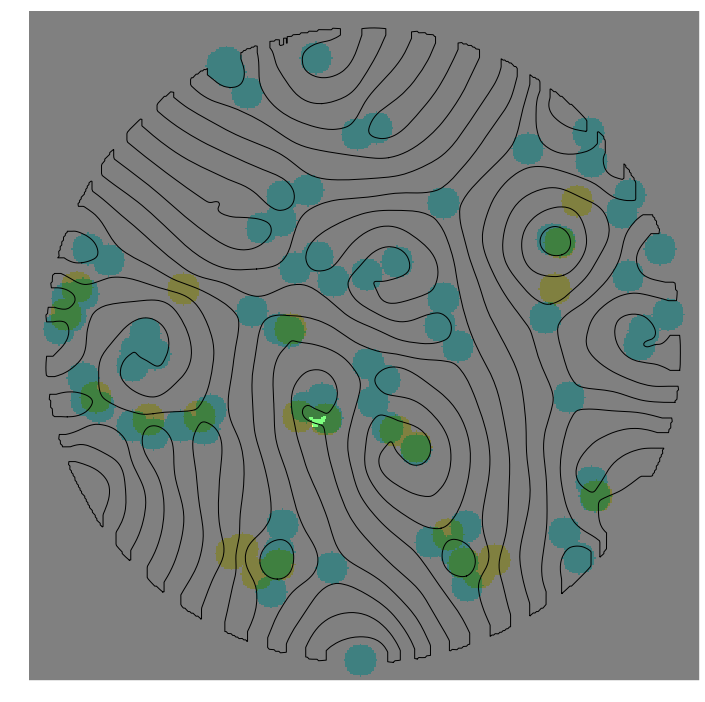

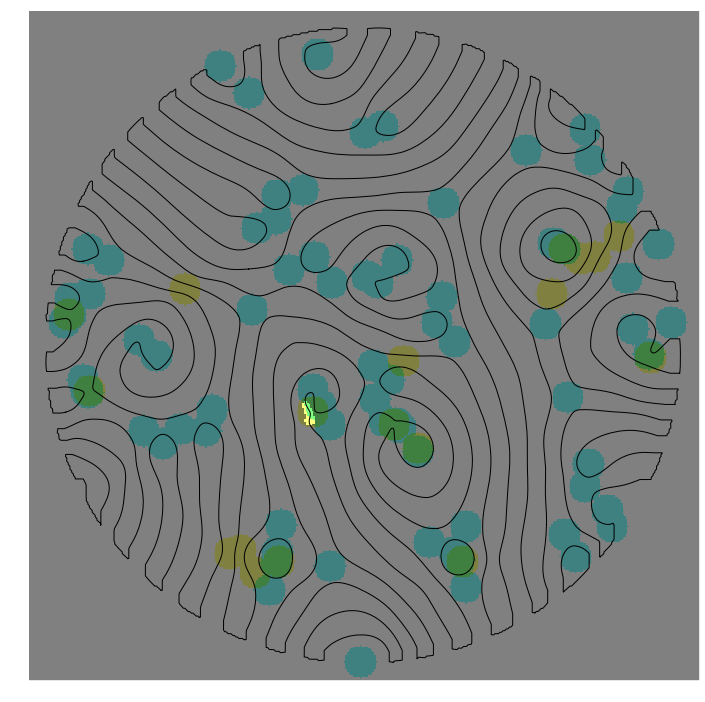

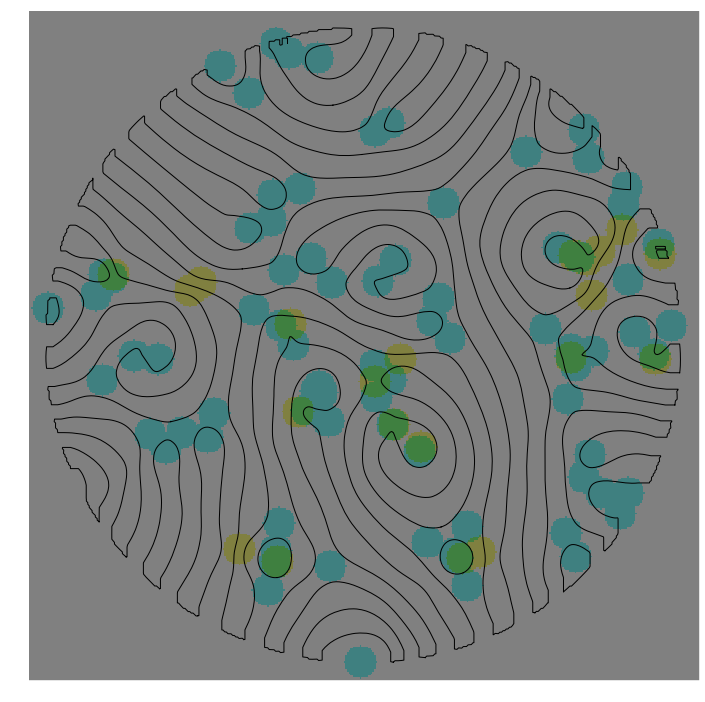

In [128]:
for idx in range(100, 200, 10):

    sigma = 3
    radius = 10
    cutoff = 0.8

    plot_single_image_lyap(idx, sigma, radius, cutoff)